# Muzeo Egizio

Notebook iterating gamma.

### Imports

In [1]:
from XRDXRFutils import Phase,DatabaseXRD, DataXRD, SpectraXRD, GaussNewton, PhaseList, PhaseMap, PhaseSearch, PhaseMapSave
from XRDXRFutils import GammaMap,ChiMap

import os
import pickle


from joblib import Parallel, delayed
import h5py
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit, least_squares

from numpy import linspace,concatenate,sqrt,log,histogram,array,unravel_index
from matplotlib.pyplot import sca,vlines,show,fill_between,sca,legend,imshow,subplots,plot,xlim,ylim,xlabel,ylabel,cm,title,scatter,colorbar,figure,vlines
from sklearn.cluster import KMeans,MiniBatchKMeans

from multiprocessing import Pool

from PIL import Image

def f_linear(x,a,b):
    return a*x + b
def f_loss(x,t,y):
    return (x[0]*t + x[1]) - y

#### Define Paths and Spectra Parameters

In [2]:
path_xrd = '/home/shared/dataXRDXRF/MuseoEgizio2022/VoltoGeroglifici/'
path_database = '/home/shared/DatabaseXRD'

path_data = 'data/' # data of intermediate results, for fast loading
path_figures = 'figures/' # figures generated by the script
path_results = 'results/' # results generated by the script: raw data, tif maps

min_theta = 17
max_theta = 43
min_intensity = 0.1 # among the tabulated peaks, selects only the ones above this threshold of intensity (scale between 0 and 1)
first_n_peaks = None # selects the first n most intense peaks (if None, leaves all the peaks)\

sigma = 0.13

## Read XRD Data

from xrd.h5

Loading: /home/shared/dataXRDXRF/MuseoEgizio2022/VoltoGeroglifici/xrd.h5
a: -1327.1 s: 2729.8 beta: 43.202


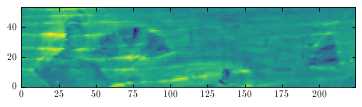

In [3]:
try:
    data = DataXRD().load_h5(path_xrd + 'xrd.h5')
except:
    print('Reading from raw data.')
    data = DataXRD().read_params(path_xrd + 'Scanning_Parameters.txt').read(path_xrd).calibrate_from_file(path_xrd + 'calibration.ini').remove_background().save_h5(path_xrd + 'xrd.h5')
    
print("a: %.1f s: %.1f beta: %.3f"%(data.opt[0],data.opt[1],data.opt[2]))

figure(figsize=(6,4))
im = imshow(data.data.sum(axis=2))
show()

## Read database

##### Define Phases
This is for simplification. Phases can be selected iteratively from database using 'Tab'

In [8]:
database = DatabaseXRD().read_cifs(path_database)

databaseEXP = DatabaseXRD().read_cifs('DatabaseExp/')

print('Phases in database:',len(database))

lazurite = database['Lazurite'][0]
hydrocerussite = database['Hydrocerussite'][0]
cinnabar = database['Cinnabar'][1]
barite = database['Barite'][0]
spinel = database['Spinel'][0]
calcite = database['Calcite'][0]
hematite = database['Hematite'][4]

huntite = database['Huntite'][0]
as4 = database['As4 O6'][0]

orpiment = database['Orpiment'][0]
cuprorivaite = database['Cuprorivaite'][0]

phases_a_s = PhaseList([hematite,orpiment,cuprorivaite,huntite,as4])

phases_a_s.get_theta(min_intensity=min_intensity,
                 min_theta = min_theta,
                 max_theta = max_theta,
                first_n_peaks = first_n_peaks)

#pmax_a = -1305.25
#pmax_s = 2676.67

if 'pmax_a' in locals():
    data.opt[0] = pmax_a
    data.opt[1] = pmax_s

Phases in database: 137


In [10]:
cinnabar.get_theta(min_intensity=0.1,min_theta=20,max_theta=53)

(array([26.51331315, 28.15070761, 31.19598604, 43.62074332, 45.75881859,
        51.77486834, 52.72567416]),
 array([0.76186, 0.219  , 1.     , 0.37672, 0.32453, 0.11862, 0.2239 ]))

In [11]:
cinnabar.safe_cif('DatabaseExp/test.cif')

In [ ]:
databaseEXP['']

PhaseMap construct a data structures for the minimization.

In [5]:
%%time
pm = GammaMap().from_data(data,phases_a_s,sigma = sigma)

CPU times: user 933 ms, sys: 102 ms, total: 1.03 s
Wall time: 1.03 s


### Autocalibration and Search
Iterates $a,s$ and $\gamma$. Choses the best phase by overlap area and fits with respect to that.

In [6]:
%%time
pm = pm.search()

CPU times: user 12.7 s, sys: 3.53 s, total: 16.2 s
Wall time: 28 s


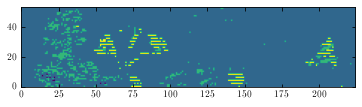

In [7]:
map_selected = pm.selected()
imshow(map_selected[...,0])
show()

In [8]:
%%time
L1loss,MSEloss,overlap_area = pm.metrics()

CPU times: user 1.76 s, sys: 1.47 s, total: 3.23 s
Wall time: 3.84 s


### Histogram of $a$

If $a$ is spead over too large area it might be that the phases are to right or a phase is missing

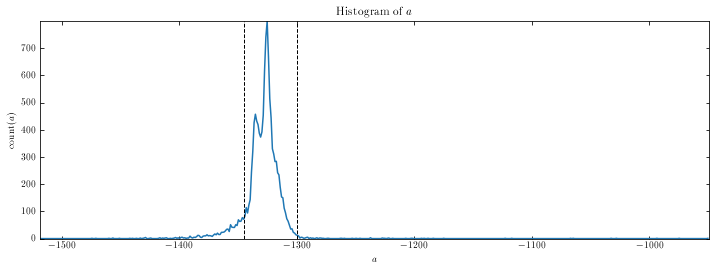

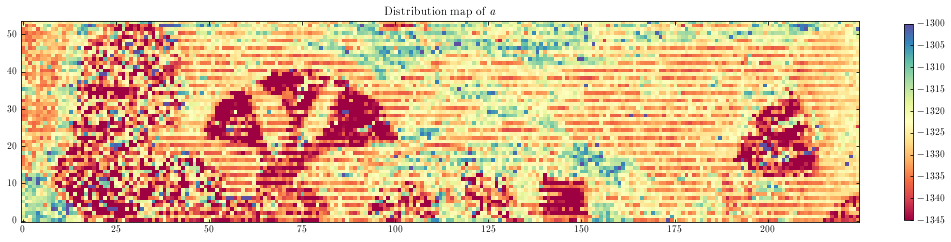

In [10]:
%matplotlib inline

opt = pm.opt()
a = opt[...,0]
s = opt[...,1]

vmin = -1345
vmax = -1300

h,b = histogram(a,bins=512)

figure(figsize=(12,4))

plot(b[:-1],h)
xlim(b[0],b[-1])
ylim(0,h.max())

vlines(vmin,0,h.max(),'k',ls='--',lw=1)
vlines(vmax,0,h.max(),'k',ls='--',lw=1)

xlabel('$a$')
ylabel(r'count($a$)')
title(r'Histogram of $a$')

figure(figsize=(16,8))
title('Distribution map of $a$')
im = imshow(a,cmap='Spectral',vmin=vmin,vmax=vmax)
colorbar(im,fraction=0.011)

show()

## Plotting the $a,s$ dependence

There is a slight notion of a second $as$ dependence but it is weak.

Linear: [   -3.77007524 -2285.2320021 ]
Cauchy: [   -2.85584046 -1074.66511911]
mean a,s: -1328.3559942862832 2722.7700378159734
most probable a,s: -1325.1680941714883 2709.8035410563425


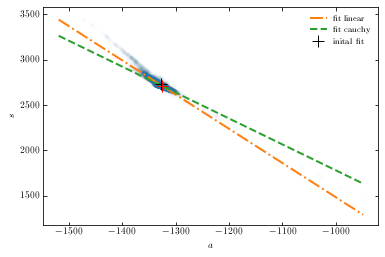

In [11]:
%matplotlib inline

opt,var = curve_fit(f_linear,a.flatten(),s.flatten())
res = least_squares(f_loss,x0=opt,args=(a.flatten(),s.flatten()),loss='cauchy')

linear_y = f_linear(a.flatten(),*opt)
cauchy_y = f_linear(a.flatten(),*res['x'])

print('Linear:',opt)
print('Cauchy:',res['x'])

plot(a.flatten(),s.flatten(),'.',alpha=0.01)

x = linspace(a.min(),a.max(),10)
plot(x,f_linear(x,*opt),'-.',lw=2,label='fit linear')
plot(x,f_linear(x,*res['x']),'--',lw=2,label='fit cauchy')
plot(data.opt[0],data.opt[1],'k+',ms=12,label='inital fit')

print('mean a,s:',a.mean(),s.mean())

legend(frameon=False)

xlabel(r'$a$')
ylabel(r'$s$')

pmax_a = b[h.argmax()]
pmax_s = f_linear(pmax_a, *res['x'])

print('most probable a,s:',pmax_a,pmax_s)

plot(pmax_a,pmax_s,'r+',ms=12,label='most likely')

show()

### Criterium

Criterium for phase selection.

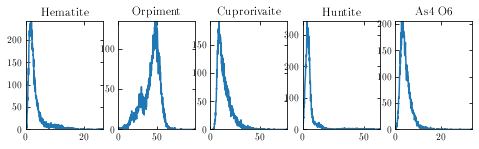

In [13]:
fig,ax = subplots(1,len(pm.phases),figsize=(8,2))

criterium = overlap_area * data.rescaling**0.5

for i,phase in enumerate(pm.phases):
    ax[i].set_title(phase.label)
    h,b = histogram(criterium[:,:,i],bins=512)
    ax[i].plot(b[:-1],h)
    ax[i].set_xlim(0,b.max())
    ax[i].set_ylim(0,h.max())
    
show()

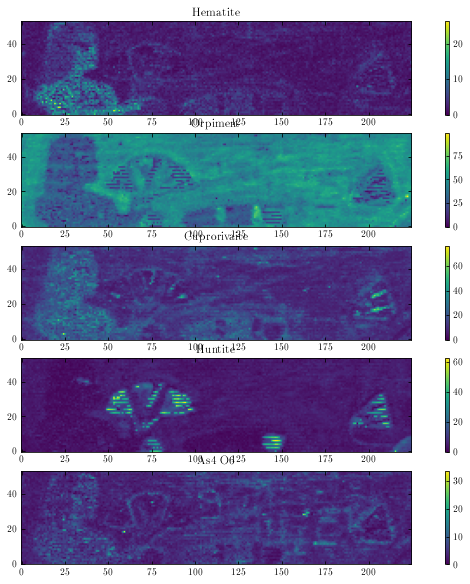

In [14]:
fig,ax = subplots(len(pm.phases),1,figsize=(12,10))

for i,phase in enumerate(pm.phases):
    ax[i].set_title(phase.label)
    p = ax[i].imshow(criterium[...,i],vmin=0)
    colorbar(p,ax = ax[i])
show()

In [25]:
new_phases = pm.select_phases(criterium,-4)

In [26]:
experimental_phases = PhaseList(new_phases)

In [42]:
from numpy import sin,pi
def thetas_to_d(thetas):
    g = sin(pi * thetas / 360)
    d = 1.541874 / (2 * g)
    return d

In [48]:
p = new_phases[0]
d = thetas_to_d(p.theta)
for d,I in zip(d,p.intensity * 1000):
    d = format(d, '.6f')
    I = format(I, '.2f')
    print(d,I)

3.677530 301.11
2.695868 1000.00
2.514417 866.86
2.203741 411.33


In [44]:
def safe_cif(name):
    with open(name, 'w') as file:
        file.write('_chemical_formula_sum  ' + formula +'\n')
        file.write('_chemical_name_common  ' + namecommon +'\n')
        file.write('_chemical_name_mineral  ' + namemineral +'\n')
        file.write('loop_\n')
        file.write('_pd_peak_d_spacing\n')
        file.write('_pd_peak_intensity\n')

        d = thetas_to_d(theta)
        print('writing d',d)
        for i, d_ in enumerate(d):
            intensity = self.intensity
            intensity = format(intensity, '.2f')
            file.write('     ' + str(format(d[i], '.6f')) + f'{str(intensity):>14}' +'\n')

In [38]:
new_phases[0].intensity

array([0.30111408, 1.        , 0.86685535, 0.41132732])

1369 (6, 19)
Hematite [-1318.61219202  2685.37750052    43.20211896]
4272 (18, 222)
Orpiment [-1330.89014862  2719.20293107    43.20211896]
4030 (17, 205)
Cuprorivaite [-1298.01914335  2632.34011239    43.20211896]
1495 (6, 145)
Huntite [-1396.57941179  3095.22622839    43.20211896]
7950 (35, 75)
As4 O6 [-1280.87538846  2524.88934569    43.20211896]


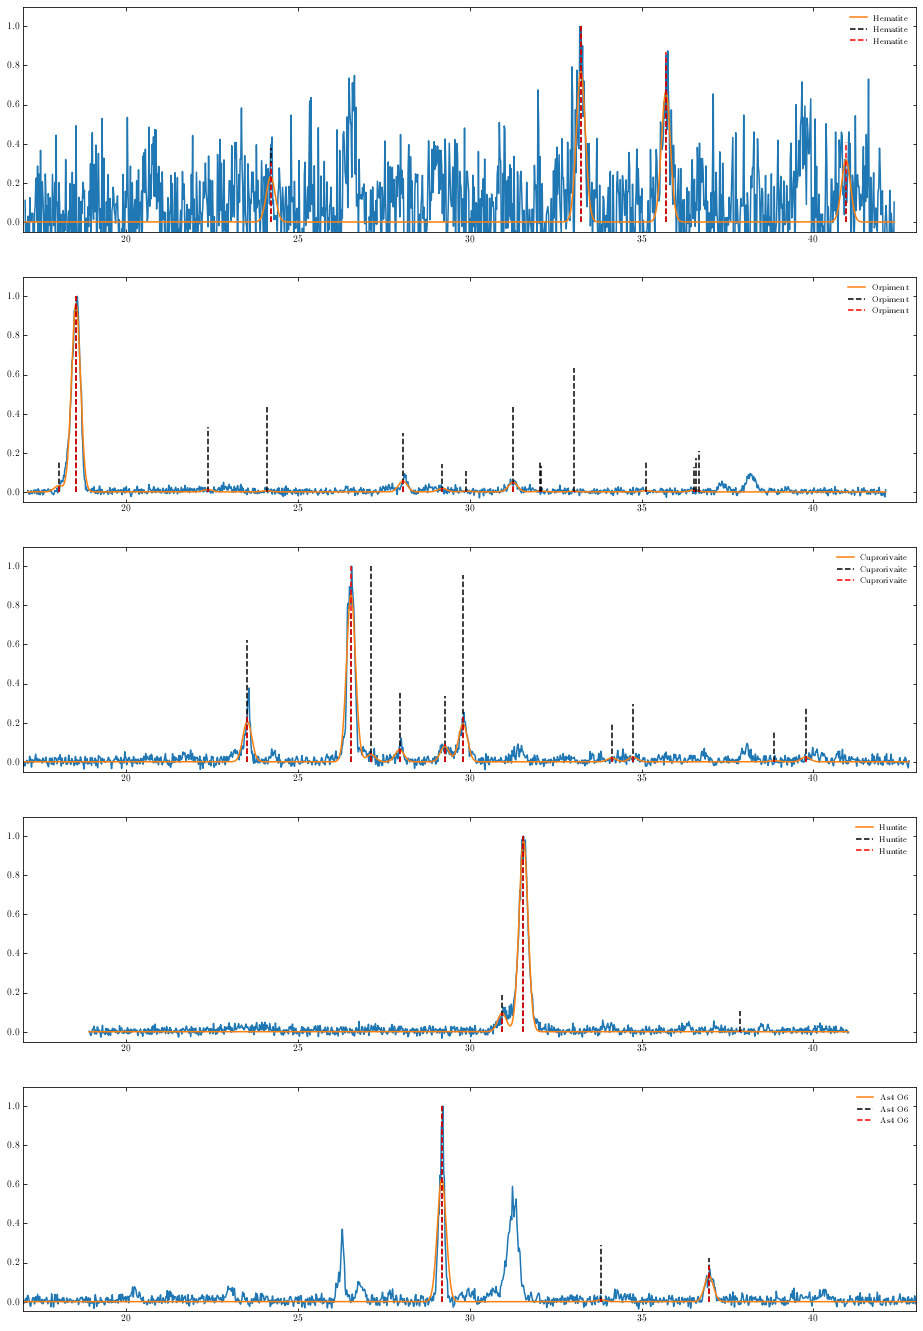

In [27]:
fig, ax = subplots(len(pm.phases),1,figsize=(16,24))

for idx,phase in enumerate(new_phases):
    point = phase['point']
    print(point,unravel_index(point,pm.shape[:2]))

    sca(ax[idx])
    
    g = pm[point][idx]
    g.fit_cycle(gamma=True,steps = 128,a=True,s=True)
    print(g.label,g.opt)
    
    g.plot_spectrum()
    g.plot(label=g.label)
    
    g.phase.plot('k')
    phase.plot('r')
    
    xlim(17,43)
    ylim(-0.05,1.1)
    legend(frameon=False)

show()

## Check single pixel

[-1301.14115439  2629.26261222    43.20211896]


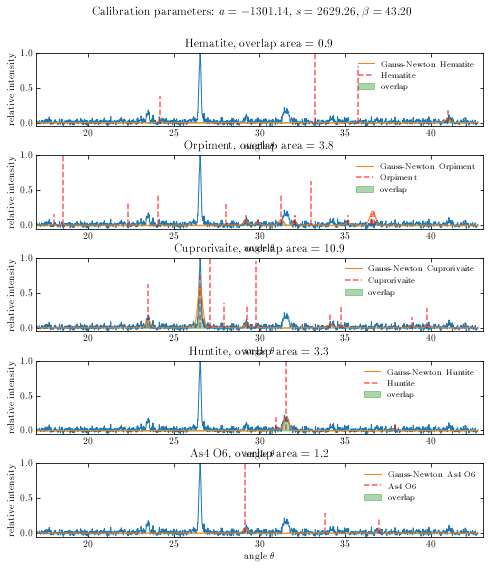

In [21]:
%matplotlib inline
selected = pm.get_pixel(210,18)

fig, axes = subplots(len(selected), 1, figsize = (8,8))
fig.subplots_adjust(hspace = 0.4, bottom = 0.06, top = 0.9)
print(selected.opt)

fig.suptitle(r'Calibration parameters: $a = %.2f$, $s=%.2f$, $\beta=%.2f$'%(selected.opt[0], selected.opt[1], selected.opt[2]))

for i in range(len(selected)):
    ax = axes[i]
    g = selected[i]
    sca(ax)

    ax.set_title(f'{g.label}, overlap area = {g.overlap_area():.1f}')
    g.plot_spectra(lw = 1)
    g.plot('-', label='Gauss-Newton %s'%g.label, lw=1)
    g.phase.plot('r', alpha=0.66)

    fill_between(g.theta.squeeze(), g.overlap(), color = 'g', alpha = 0.33, label='overlap')

    legend(frameon = False)
    ax.set_ylim(-0.05, 1)
    ax.set_xlim(17, 43)
    ax.set_xlabel(r'angle $\theta$')
    ax.set_ylabel(r'relative intensity')
    
show()

[-1299.56285938  2624.17824578    43.20211896]
[[0.17716421 0.76567293 0.01265515 0.03600917 0.1866321  0.02692797
  0.25256991 0.09822333 0.11730195 0.06657268]]


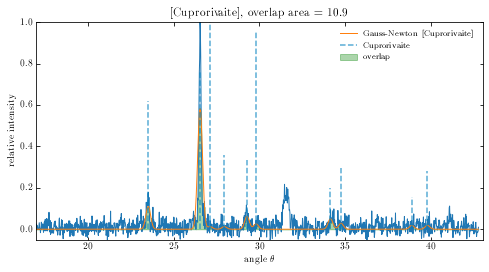

In [22]:
g = GaussNewton(PhaseList([cuprorivaite]),selected.spectrum,sigma=sigma)

g.fit_cycle(gamma=True,steps = 128,a=True,s=True)
print(g.opt)

print(g.gamma)

figure(figsize=(8,4))

title(f'{g.label}, overlap area = {g.overlap_area():.1f}')

g.plot_spectra(lw = 1)
g.plot('-', label='Gauss-Newton %s'%g.label, lw=1)
g.phase.plot(alpha=0.66)

fill_between(g.theta, g.overlap(), color = 'g', alpha = 0.33, label='overlap')

legend(frameon = False)

ylim(-0.05, 1)
xlim(17, 43)
xlabel(r'angle $\theta$')
ylabel(r'relative intensity')

show()

### Fit errrors

Plotting the histograms and maps of the error for each phase. 

In [15]:
criterium = overlap_area * data.rescaling**0.5

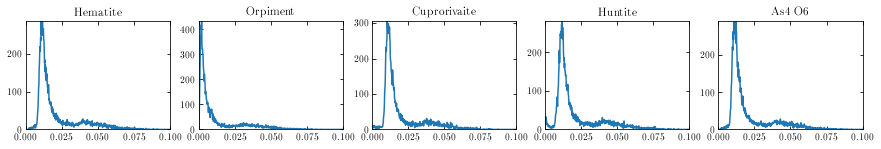

In [16]:
fig,ax = subplots(1,len(pm.phases),figsize=(15,2))

for i,phase in enumerate(pm.phases):
    ax[i].set_title(phase.label)
    h,b = histogram(MSEloss[:,:,i],bins=512,range=(0,0.1))
    ax[i].plot(b[:-1],h)
    ax[i].set_xlim(0,b.max())
    ax[i].set_ylim(0,h.max())
    
show()

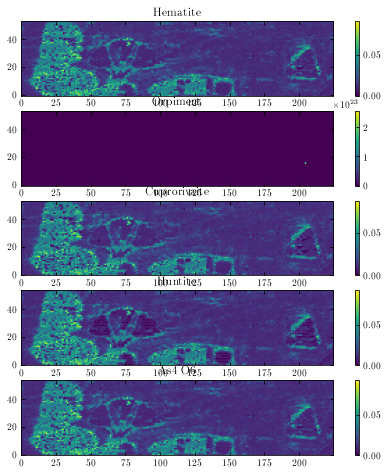

In [17]:
fig,ax = subplots(len(pm.phases),1,figsize=(8,8))

for i,phase in enumerate(pm.phases):
    ax[i].set_title(phase.label)
    p = ax[i].imshow(MSEloss[:,:,i],vmin=0)
    p = colorbar(p,ax = ax[i],fraction=0.04)
    
show()